In [1]:
%matplotlib inline



# Non-parametric 1 sample cluster statistic on single trial power

This script shows how to estimate significant clusters
in time-frequency power estimates. It uses a non-parametric
statistical procedure based on permutations and cluster
level statistics.

The procedure consists of:

  - extracting epochs
  - compute single trial power estimates
  - baseline line correct the power estimates (power ratios)
  - compute stats to see if ratio deviates from 1.


In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#
# License: BSD-3-Clause

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


## Set parameters



In [5]:
data_path = sample.data_path()
meg_path = data_path + '/MEG/sample'
raw_fname = meg_path + '/sample_audvis_raw.fif'
tmin, tmax, event_id = -0.3, 0.6, 1

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

include = []
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True,
                       stim=False, include=include, exclude='bads')

# Load condition 1
event_id = 1
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6))
# just use right temporal sensors for speed
epochs.pick_channels(mne.read_vectorview_selection('Right-temporal'))
evoked = epochs.average()

# Factor to down-sample the temporal dimension of the TFR computed by
# tfr_morlet. Decimation occurs after frequency decomposition and can
# be used to reduce memory usage (and possibly computational time of downstream
# operations such as nonparametric statistics) if you don't need high
# spectrotemporal resolution.
decim = 5
freqs = np.arange(8, 40, 2)  # define frequencies of interest
sfreq = raw.info['sfreq']  # sampling in Hz
tfr_epochs = tfr_morlet(epochs, freqs, n_cycles=4., decim=decim,
                        average=False, return_itc=False, n_jobs=1)

# Baseline power
tfr_epochs.apply_baseline(mode='logratio', baseline=(-.100, 0))

# Crop in time to keep only what is between 0 and 400 ms
evoked.crop(-0.1, 0.4)
tfr_epochs.crop(-0.1, 0.4)

epochs_power = tfr_epochs.data

Opening raw data file /Users/nick/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metadata
72 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 72 events and 541 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting 

In [10]:
epochs

Number of events,54
Events,1: 54
Time range,-0.300 – 0.599 sec
Baseline,-0.300 – 0.000 sec


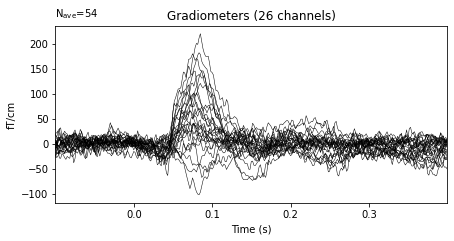

In [12]:
x=evoked.plot()

In [9]:
epochs_power.shape

(54, 26, 16, 61)

## Define adjacency for statistics
To compute a cluster-corrected value, we need a suitable definition
for the adjacency/adjacency of our values. So we first compute the
sensor adjacency, then combine that with a grid/lattice adjacency
assumption for the time-frequency plane:



In [6]:
sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    tfr_epochs.info, 'grad')
# Subselect the channels we are actually using
use_idx = [ch_names.index(ch_name.replace(' ', ''))
           for ch_name in tfr_epochs.ch_names]
sensor_adjacency = sensor_adjacency[use_idx][:, use_idx]
assert sensor_adjacency.shape == \
    (len(tfr_epochs.ch_names), len(tfr_epochs.ch_names))
assert epochs_power.data.shape == (
    len(epochs), len(tfr_epochs.ch_names),
    len(tfr_epochs.freqs), len(tfr_epochs.times))
adjacency = mne.stats.combine_adjacency(
    sensor_adjacency, len(tfr_epochs.freqs), len(tfr_epochs.times))

# our adjacency is square with each dim matching the data size
assert adjacency.shape[0] == adjacency.shape[1] == \
    len(tfr_epochs.ch_names) * len(tfr_epochs.freqs) * len(tfr_epochs.times)

Reading adjacency matrix for neuromag306planar.


## Compute statistic



In [7]:
threshold = 3.
n_permutations = 50  # Warning: 50 is way too small for real-world analysis.
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(epochs_power, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True)

stat_fun(H1): min=-6.455144 max=8.265125
Running initial clustering
Found 50 clusters
Permuting 49 times...


  0%|          |  : 0/49 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


## View time-frequency plots



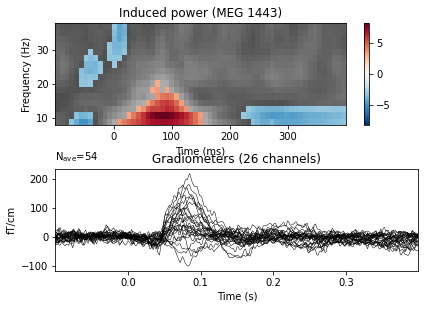

In [8]:
evoked_data = evoked.data
times = 1e3 * evoked.times

plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Create new stats image with only significant clusters
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

# Just plot one channel's data
ch_idx, f_idx, t_idx = np.unravel_index(
    np.nanargmax(np.abs(T_obs_plot)), epochs_power.shape[1:])
# ch_idx = tfr_epochs.ch_names.index('MEG 1332')  # to show a specific one

vmax = np.max(np.abs(T_obs))
vmin = -vmax
plt.subplot(2, 1, 1)
plt.imshow(T_obs[ch_idx], cmap=plt.cm.gray,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(T_obs_plot[ch_idx], cmap=plt.cm.RdBu_r,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Induced power ({tfr_epochs.ch_names[ch_idx]})')

ax2 = plt.subplot(2, 1, 2)
evoked.plot(axes=[ax2], time_unit='s')
plt.show()